# Examples

`solpolpy` is a solar polarization resolver based on [Deforest et al. 2022](https://doi.org/10.3847/1538-4357/ac43b6).

It converts between various polarization formats, e.g. from the native three triple version from observations (also known as the MZP convention) to polarization brightness (pB) and total polarization (B), Stokes I, Q and U, etc. An example of transforming the polarization basis using the LASCO/C2 images is shown in the image below. The images at polarizing angles of -60°, 0° and +60° is shown in the top panel as Bm, Bz and Bp respectively. The bottom panel shows the output of the `solpolpy` to convert the initial basis to the Stokes I, Q and U.

solpolpy is invoked using a simple interface:`output = sp.resolve(input_data, out_system)` where the `input_data` parameter is an appropriate NDCollection (a collection of [SunPy NDCubes](https://docs.sunpy.org/projects/ndcube/en/stable/)), such as a triplet of polarized images. `out_system` is the desired output polarization state (MZP, BtBr, Stokes, BpB, Bp3, or Bthp). It has a utility function to load data into the expected NDCollection format called `load_data`. There is also a plotting utility to plot any collection called `plot_collection`. 

## Polarization systems handled by solpolpy
- Minus, Zero, Plus in solar frame (mzpsolar): Triplet of images taken at -60°, 0°, and +60° polarizing angles with a reference angle set to solar frame.
- Minus, Zero, Plus in instrument frame (mzpinstru): Triplet of images taken at -60°, 0°, and +60° polarizing angles with a reference angle set to instrument frame.
- Tangential and Radial Brightness (BtBr): Pair of images with polarization along the tangential and radial direction with respect to the Sun respectively.
- Stokes (Stokes): Total (unpolarized) brightness (I), polarized brightness along vertical and horizontal axes (Q) and polarized brightness along ±45° (U) .
- Brightness, polarized Brightness (BpB): Total (unpolarized) brightness and ‘excess polarized’ brightness images pair respectively.
- Brightness, polarized Brightness, polarized Brightness orthogonal (Bp3): Analogous to Stokes I, Q and U, but rotates with α around the Sun unlike the later with fixed frame of reference of the instrument.
- Brightness, theta, phi (Bthp): System with total (unpolarized) brightness, angle and degree of polarization.
- N polarization states (npol): arbitrary angles of polarized data

## Import Data

Import an example STEREO polarzation triplet dataset from 2010-04-03 at 10:10 UT. These can be substituted with any file paths you have. 

In [1]:
# Import packages
import glob
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib import rcParams
from solpolpy import resolve, load_data, plot_collection, get_colormap_str #, generate_rgb_image, collection_to_maps
from solpolpy.plotting import generate_rgb_image
from solpolpy.util import collection_to_maps
rcParams['font.family'] = 'serif'
warnings.filterwarnings('ignore')

stereo_paths = glob.glob('data/stereo*.fts')

Use the solpolpy `load_data` function to import data from FITS files. Alternatively, you can pass FITS filenames to the `resolve` method showcased later. However, you have more control and can visualize the inputs if you use `load_data`. In this case, we specify `use_instrument_mask=True` because we want to load the data with the solpolpy-provided instrument mask. 

In [2]:
stereo_collection = load_data(stereo_paths, use_instrument_mask=True)

`stereo_collection` is an NDCollection. If you're not familiar with these, please see the NDCube documentation (http://docs.sunpy.org/projects/ndcube/). They're essentially data containers that couple multiple aspects of data together, e.g. the world coordinate system (WCS), the data, uncertainty, metadata. 

For any collection, you can use the `.keys()` method to see the keys that solpolpy loaded. 

In [3]:
stereo_collection.keys()

dict_keys(['240.0 deg', '120.0 deg', '0.0 deg'])

In this case, we can see they are angle measurements (in degrees). If we want to know more, we can look at the appropriate cube:

In [4]:
stereo_collection['240.0 deg']

NDCube
------
Dimensions: [2048. 2048.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: uint16

It's particularly helpful to look at the "POLAR" keyword that solpolpy adds to metadata. That tracks what kind of file we're looking at. In this case it returns 240.0 because we're looking at an image with a polarizer of 240.0 degrees. 

In [5]:
stereo_collection['240.0 deg'].meta['POLAR']

240.0

## View the STEREO triplet input data

solpolpy provides two helpful functions for viewing data: 
- `get_colormap_str` determines the appropriate colormap string to use for the dataset. 
- `plot_collection` visualizes the collection. There are many optional arguments to this function. It also supports the parameters of matplotlib.imshow. We suggest you look at the documentation's help to see them all.

In [6]:
help(plot_collection)

Help on function plot_collection in module solpolpy.plotting:

plot_collection(collection, figsize=(8, 8), show_colorbar=False, lat_ticks=None, lon_ticks=None, major_formatter='dd', xlabel='HP Longitude', ylabel='HP Latitude', vmin=None, vmax=None, cmap='Greys_r', ignore_alpha=True, fontsize=18, **kwargs)
    Plot a solpolpy NDCollection input or output.

    Parameters
    ----------
    collection : NDCollection, ndarray, or 3D color_image.
        collection to visualize
    figsize : Tuple[float, float]
        figure size according to Matplotlib
    show_colorbar : bool
        whether to show a colorbar
    lat_ticks : Optional[np.ndarray]
        if provided, shows as the tick marks for latitude. default values used otherwise.
    lon_ticks : Optional[np.ndarray]
        if provided, shows as the tick marks for longitude. default values used otherwise.
    major_formatter : str
        the formatter for major tickmarks as specified by Matplotlib
    xlabel : str
        label fo

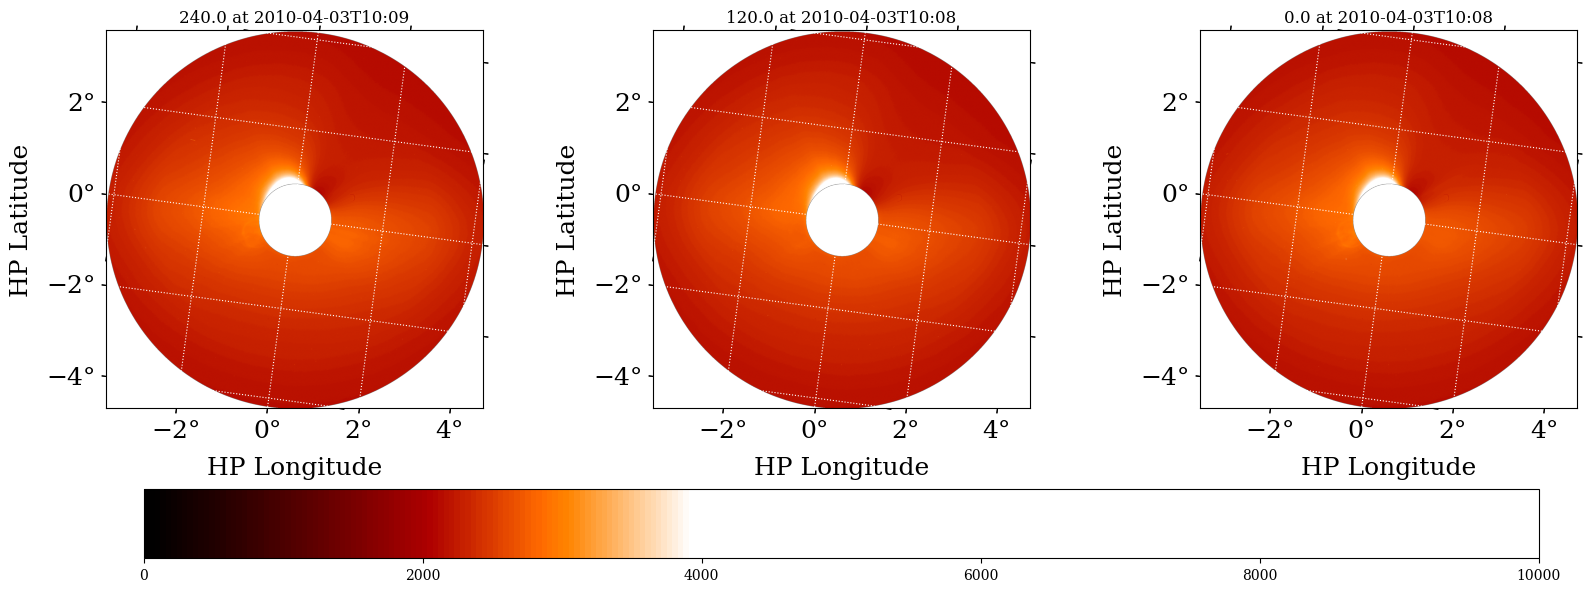

In [7]:
cmap = get_colormap_str(stereo_collection['0.0 deg'].meta)
plot_collection(stereo_collection, 
                figsize=(20, 7),
                vmin=0, 
                vmax=10_000, 
                cmap=cmap, 
                show_colorbar=True)
plt.show()

## 1. Resolve STEREO triplet into a Brightness and Polarized Brightness pair 

The native polarization system (npol or mzp) for STEREO is not all that directly helpful for solar physics science. Instead, we convert the data into a different polarization system, namely the total brightness (B) and polarized brightness (pB) system. We use solpolpy's `resolve` method to do this and just pass in our collection and the string `"BpB"` indicating that's our desired output system. 

Alternatively, you can pass the FITS filenames in as a list. This avoids having to manually load them first. 

In [8]:
output_bpb = resolve(stereo_collection, 'bpb')

As noted earlier, we can look at any collection's keys. 

In [9]:
output_bpb.keys()

dict_keys(['B', 'pB', 'alpha'])

In this example we have converted the STEREO image triplet into a brightness - polarized brightness (BpB) pair. We see three keys are present in the output NDcollection, the brightness 'B', and, the polarized brightness 'pB' array, as well as the alpha array used to produce the pair. More information on the alpha parameter can be found in  [Deforest et al. 2022](https://doi.org/10.3847/1538-4357/ac43b6)

To do science on the resulting data, you can access it directly. 

In [10]:
output_bpb['B'].data

array([[4118.66666667, 4117.33333333, 4116.        , ..., 4118.66666667,
        4118.66666667, 4117.33333333],
       [4122.66666667, 4121.33333333, 4117.33333333, ..., 4118.66666667,
        4120.        , 4118.66666667],
       [4125.33333333, 4121.33333333, 4117.33333333, ..., 4118.66666667,
        4120.        , 4118.66666667],
       ...,
       [4120.        , 4116.        , 4113.33333333, ..., 4114.66666667,
        4117.33333333, 4117.33333333],
       [4121.33333333, 4118.66666667, 4116.        , ..., 4118.66666667,
        4118.66666667, 4117.33333333],
       [4124.        , 4121.33333333, 4118.66666667, ..., 4121.33333333,
        4120.        , 4118.66666667]], shape=(2048, 2048))

An important note is that the "POLAR" keyword is now "B". This can be helpful if you forget what data you're dealing with. 

In [11]:
output_bpb['B'].meta['POLAR']

'B'

We can look at this resolved data the same way we looked at the inputs by using `plot_collection`. 

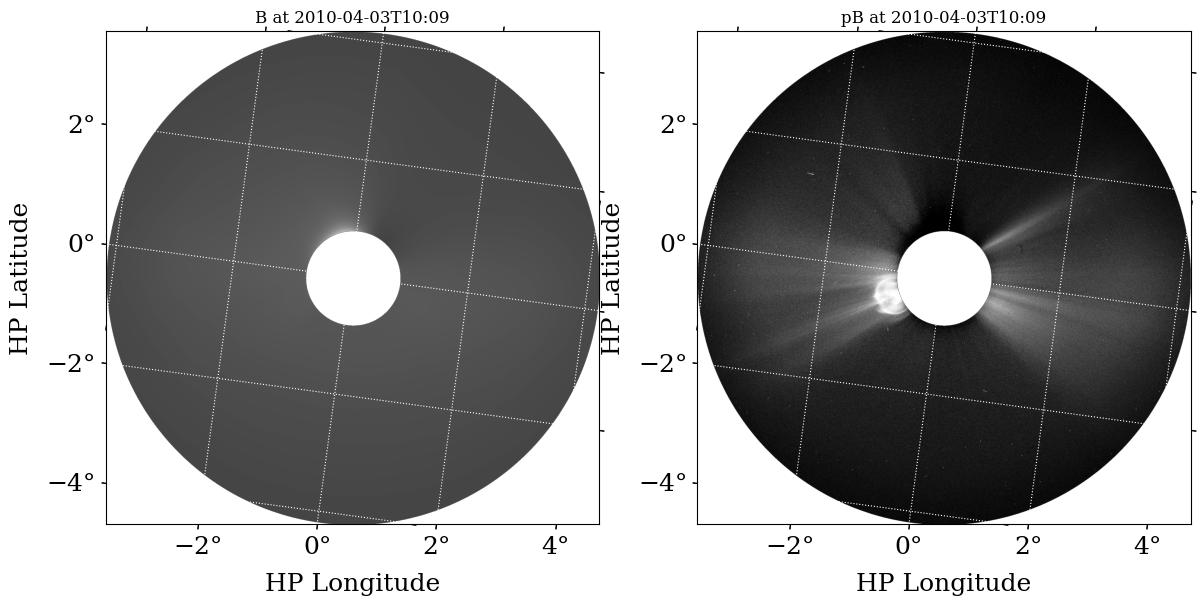

In [12]:
plot_collection(output_bpb, figsize=(14,8), vmin=0, vmax=[20000, 200])
plt.show()

## 2. Resolve STEREO brightness and polarized brightness pair into a Stokes triplet
We could convert this data to the Stokes system now if we wanted. 

In [13]:
output_stokes = resolve(output_bpb, 'stokes')

Once again we can look at the keys in the output NDcollection. 

In [14]:
output_stokes.keys()

dict_keys(['I', 'Q', 'U'])

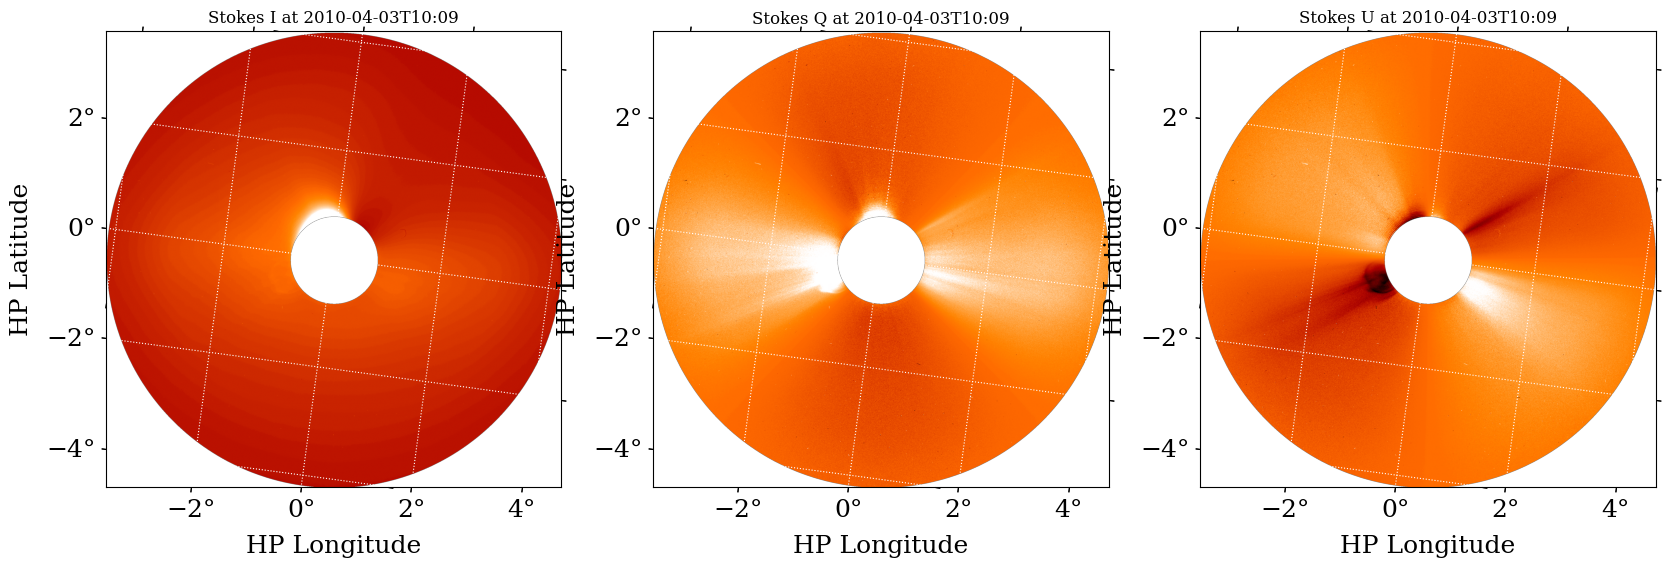

In [15]:
cmap = get_colormap_str(stereo_collection['0.0 deg'].meta)
plot_collection(output_stokes, 
                figsize=(20, 7), 
                vmin=[0, -200, -200],
                vmax=[20000, 500, 500],
                cmap=cmap, 
                show_colorbar=False)
plt.show()

## 3. Taking the shortcut
Instead of having to convert from STEREO's native MZP to BpB and then to Stokes, we can ask solpolpy to resolve from MZP directly to Stokes as well! We'll run the `resolve` command with the original STEREO data and convert directly to Stokes. solpolpy figures out how to do this conversion behind the scenes. If you ever ask for an impossible transformation, it'll let you know.

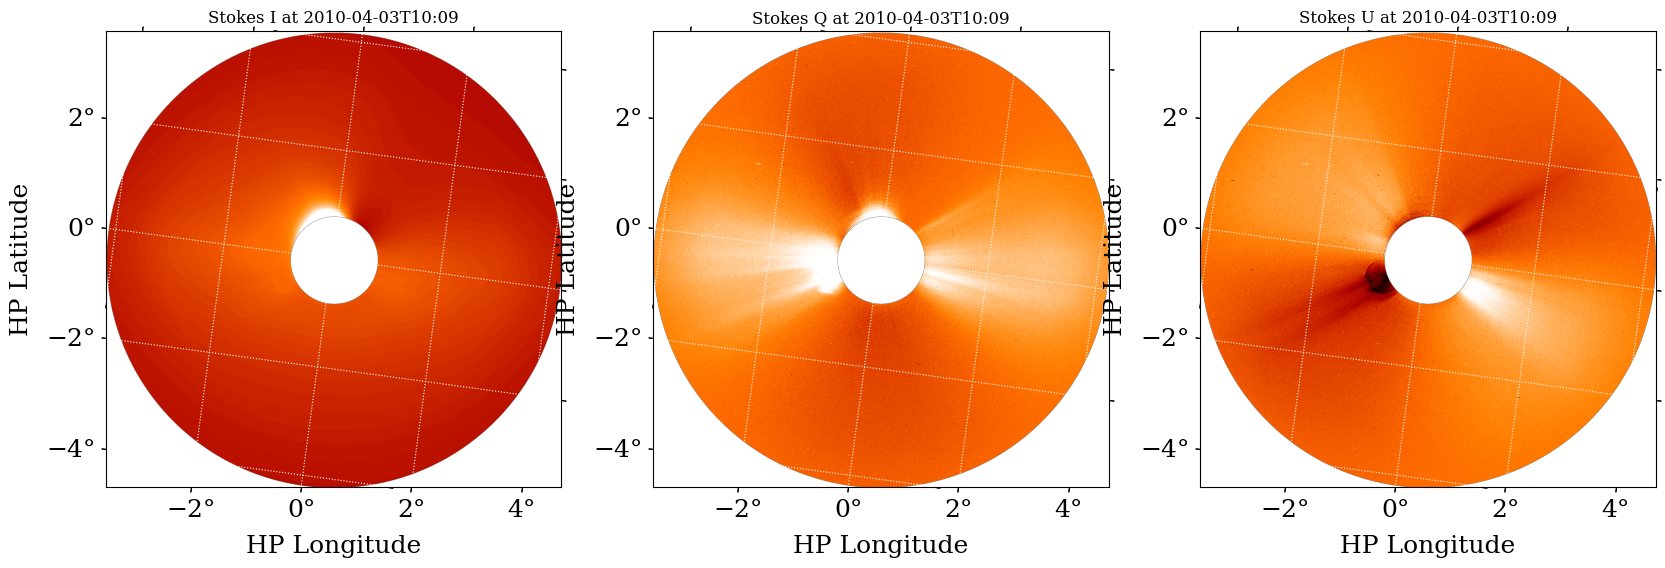

In [16]:
output_stokes2 = resolve(stereo_collection, 'stokes')

cmap = get_colormap_str(stereo_collection['0.0 deg'].meta)
plot_collection(output_stokes2, 
                figsize=(20, 7), 
                vmin=[0, -200, -200],
                vmax=[20000, 500, 500],
                cmap=cmap, 
                show_colorbar=False)
plt.show()

Our results are the same either way!

## 4. Generating RGB color image from MZP triplets

solpolpy also supports RGB visualization of MZP triplets based on the color analogy of polarization presented in [Deforest et al. 2022](https://doi.org/10.3847/1538-4357/ac43b6) and tested on eclipse image by [Patel et al. 2023](https://iopscience.iop.org/article/10.3847/2515-5172/ad0b0d/meta). Once the polarization state is resolved as `"mzpsolar"`, one can use the inherent funtion with choise of radial gradient filters present in `sunkit_image`.

The following example demostrate the use of this function using the STEREO/COR-2 data presented above by first converting the polarization base to `"mzpsolar"`.

In [34]:
output_mzp = resolve(stereo_collection, 'mzpsolar')

totalbg =  (output_mzp['M'].data+output_mzp['Z'].data+output_mzp['P'].data)/3 #ad hoc background for example purpose only
output_mzp['M'].data[...] = (output_mzp['M'].data[...] - totalbg)
output_mzp['Z'].data[...] = (output_mzp['Z'].data[...] - totalbg)
output_mzp['P'].data[...] = (output_mzp['P'].data[...] - totalbg)

In [35]:
outcol = generate_rgb_image(output_mzp,
                            enhancement_method='nrgf',
                            mask_params={'inner_radius': 3, 'outer_radius': 15},
                            enhancement_params={'application_radius':3*u.R_sun})

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Miss

(<Figure size 800x800 with 1 Axes>,
 [<Axes: xlabel='HP Longitude', ylabel='HP Latitude'>])

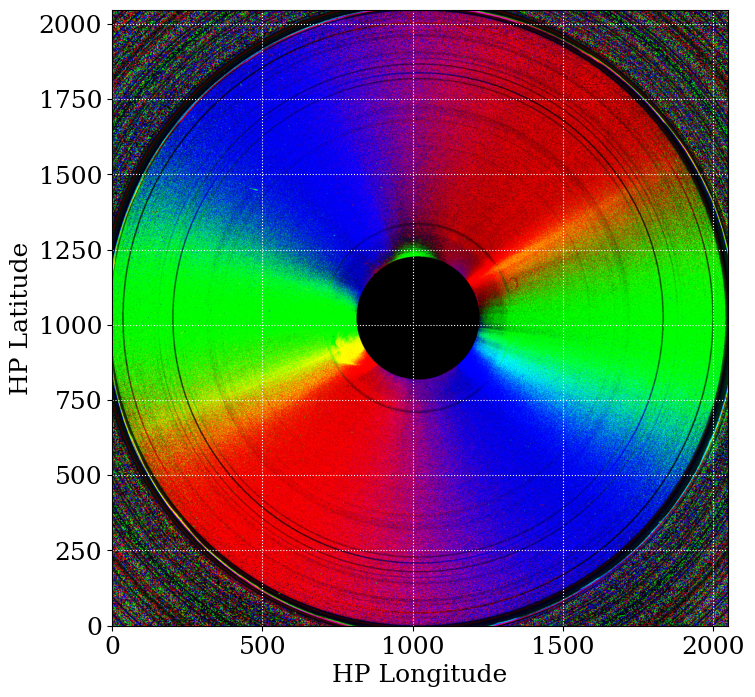

In [36]:
plot_collection(outcol, origin='lower')

## 5. Use solpolpy output as sunpyMap

solpolpy outputs which are NDCollection objects can also be transformed into sunpyMaps using `collection_to_maps` function within solpolppy to take advantage of sunpy Maps related features. The output of this function is a list of sunpyMap, so one needs to ensure the order of keys in the NDCollection being passed.


In [27]:
outmap = collection_to_maps(output_mzp)

The output is a list of sunpy Maps in the order of NDCollection keys. Now we can also plot in maps style as shown below for one of the maps.

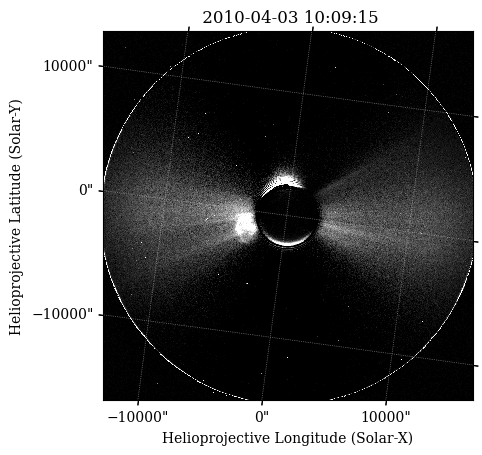

In [28]:
outmap[1].plot(vmin=0, vmax=70)

We can use other features of sunpy Maps such as cropping a Map and then plotting it.

In [29]:
top_right = SkyCoord(0 * u.arcsec, -200 * u.arcsec, frame=outmap[1].coordinate_frame)
bottom_left = SkyCoord(-5000 * u.arcsec, -5000 * u.arcsec, frame=outmap[1].coordinate_frame)
out_submap = outmap[1].submap(bottom_left, top_right=top_right)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


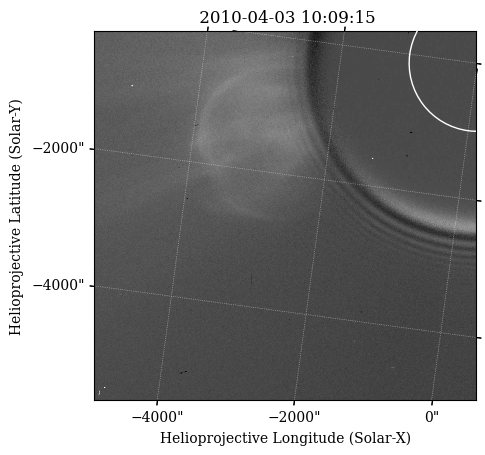

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection=out_submap)
image = out_submap.plot(axes=ax)
out_submap.draw_limb(axes=ax)
ax.set_title(ax.get_title())

plt.show()